# 평가조건

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
    - 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
    - U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.
    - 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

# 모듈 임포트

In [1]:
import os
import cv2
import numpy as np

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

import matplotlib.pyplot as plt

# 데이터 불러오기

In [2]:
train_path = os.getenv('HOME')+'/aiffel/exploration/ex16/train/'
val_path = os.getenv('HOME')+'/aiffel/exploration/ex16/val/'
print("train 데이터셋의 갯수 :", len(os.listdir(train_path)))
print("valid 데이터셋의 갯수 :", len(os.listdir(val_path)))

train 데이터셋의 갯수 : 1000
valid 데이터셋의 갯수 : 5


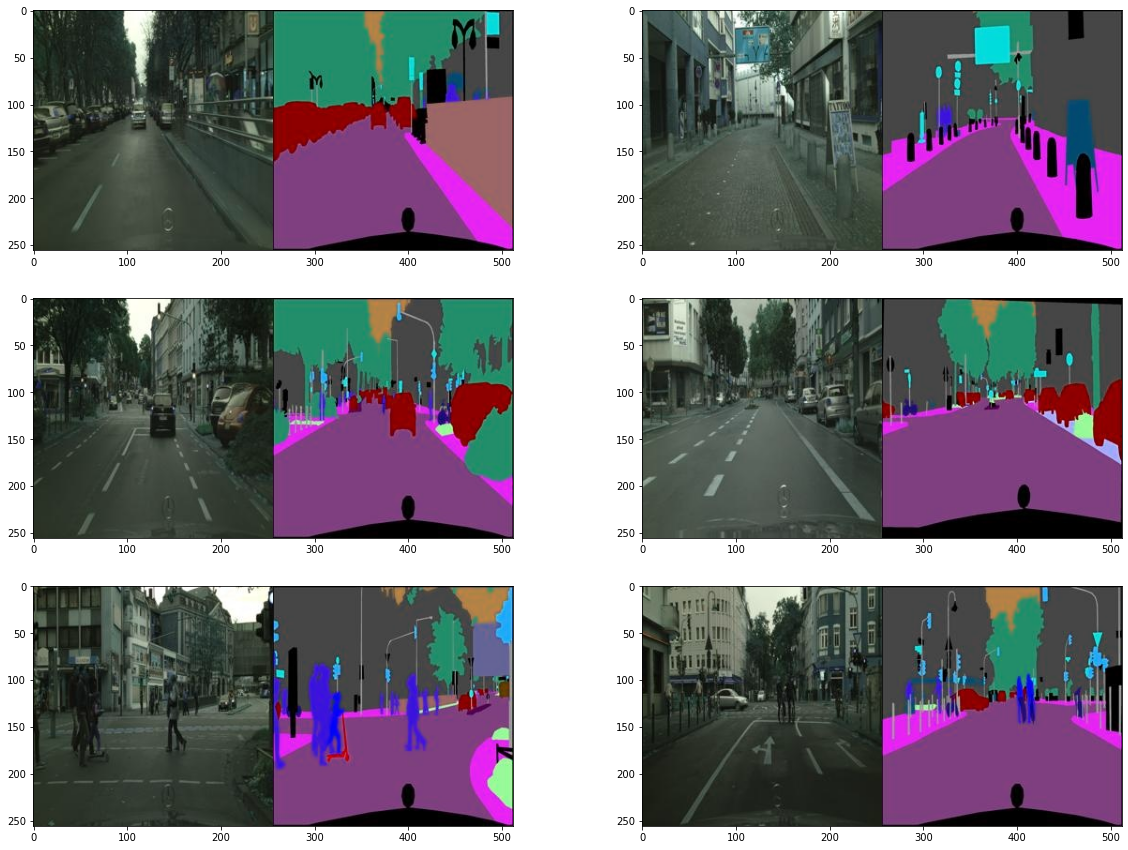

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

6개의 랜덤 이미지를 확인하였습니다.

# 데이터 전처리

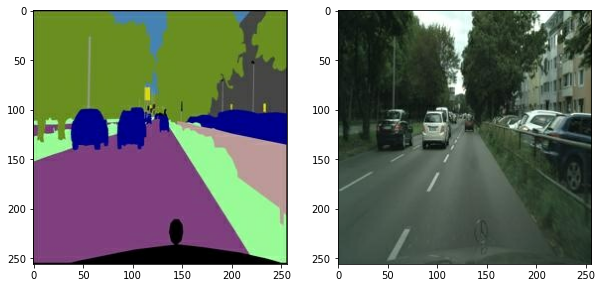

In [4]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)

f = train_path + os.listdir(train_path)[1]
colored, sketch = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(colored)) 
plt.subplot(1,2,2); plt.imshow(denormalize(sketch))

위와 같이 두 개 이미지로 나누었습니다. 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표입니다.

학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

# 데이터 Argumentation

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(colored, sketch):
    stacked = tf.concat([colored, sketch], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

50%의 확률로 좌우로 뒤집거나 상하로 뒤집거나 90도 단위로 회전을 시켜 이미지를 증강시켜주었습니다.

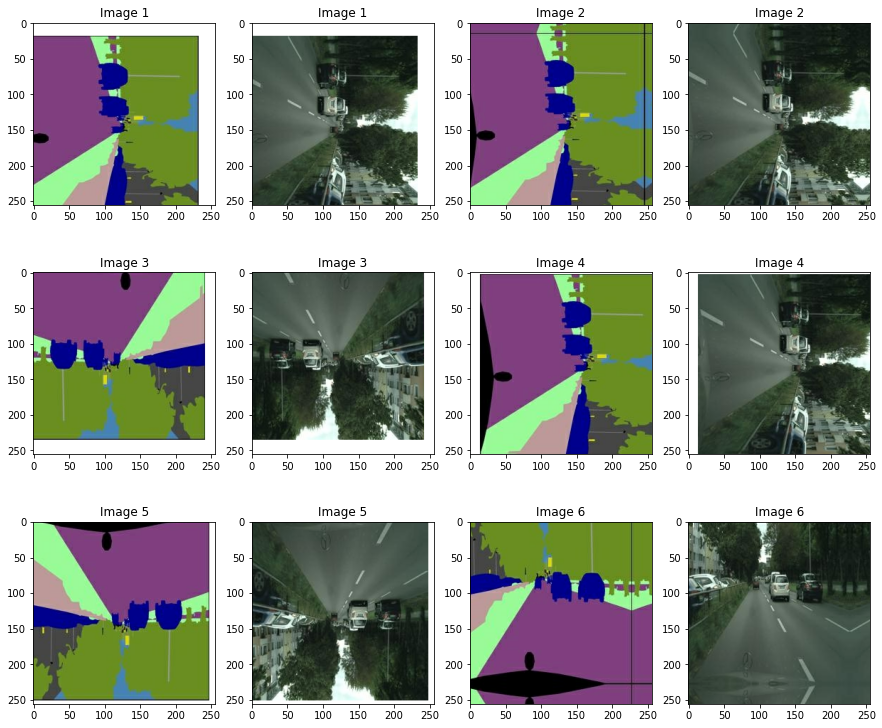

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_colored, augmented_sketch = apply_augmentation(colored, sketch)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    img_n += 1

증강이 잘 되었는지 1개의 데이터만 확인해보겠습니다.

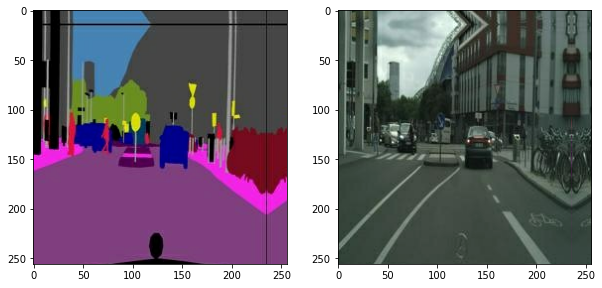

In [7]:
from tensorflow import data

def get_train(img_path):
    colored, sketch = load_img(img_path)
    colored, sketch = apply_augmentation(colored, sketch)
    return colored, sketch

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
colored, sketch = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(colored[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(sketch[0].astype(np.uint8))

# 모델 구성하기

## Generator 구현하기

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

## Discriminator 구현하기

In [10]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [11]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

# 학습 및 테스트하기

In [12]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [13]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [14]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [15]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (colored, sketch) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(colored, sketch)
                
    if epoch % 5 == 0:
        print(f"EPOCH[{epoch}] \
                \nGenerator_loss:{g_loss.numpy():.4f} \
                \nL1_loss:{l1_loss.numpy():.4f} \
                \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[5]                 
Generator_loss:1.7602                 
L1_loss:0.1549                 
Discriminator_loss:0.5710

EPOCH[10]                 
Generator_loss:2.2331                 
L1_loss:0.1502                 
Discriminator_loss:0.5617

EPOCH[15]                 
Generator_loss:1.1247                 
L1_loss:0.1676                 
Discriminator_loss:0.6818

EPOCH[20]                 
Generator_loss:0.6348                 
L1_loss:0.1907                 
Discriminator_loss:0.8632

EPOCH[25]                 
Generator_loss:0.8266                 
L1_loss:0.1607                 
Discriminator_loss:0.7099

EPOCH[30]                 
Generator_loss:2.3534                 
L1_loss:0.1918                 
Discriminator_loss:0.7510

EPOCH[35]                 
Generator_loss:1.2854                 
L1_loss:0.1748                 
Discriminator_loss:0.5143

EPOCH[40]                 
Generator_loss:2.2523                 
L1_loss:0.1814                 
Discriminator_loss:0.2454

E

# 결과 확인

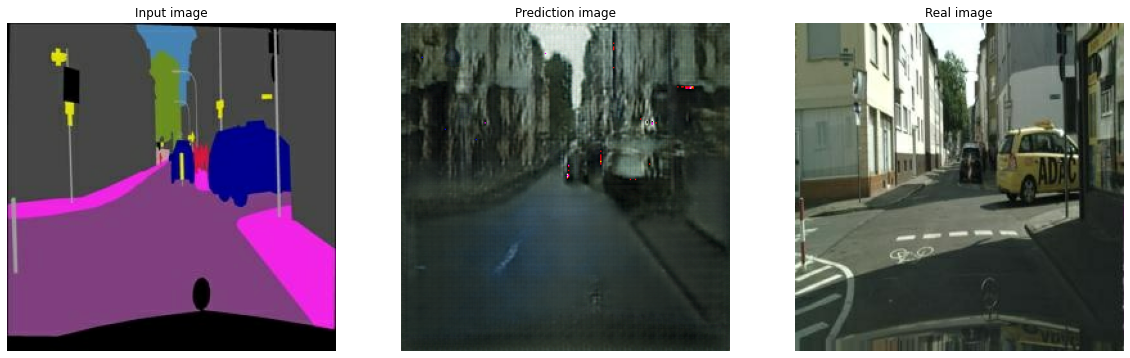

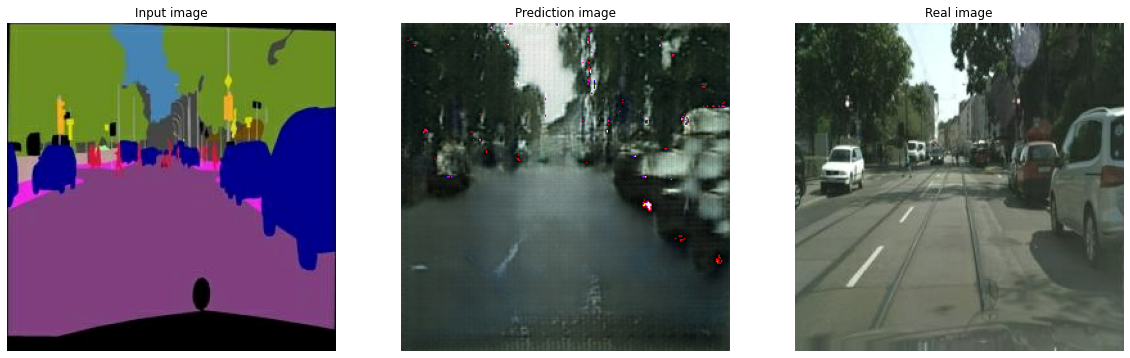

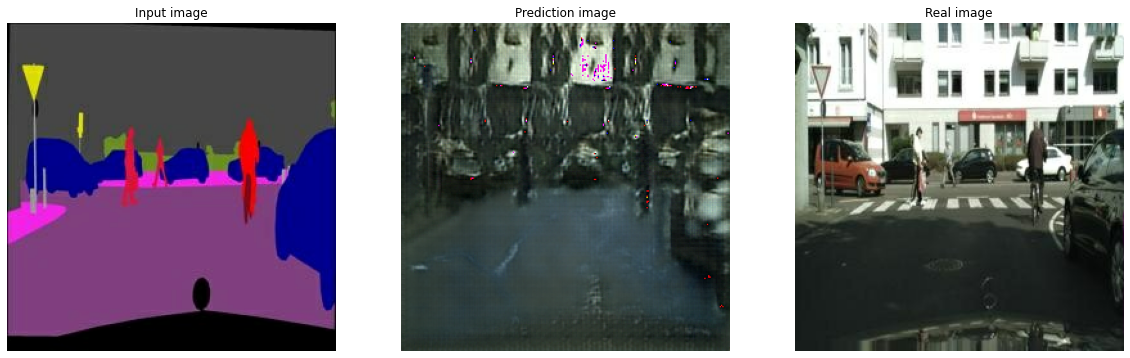

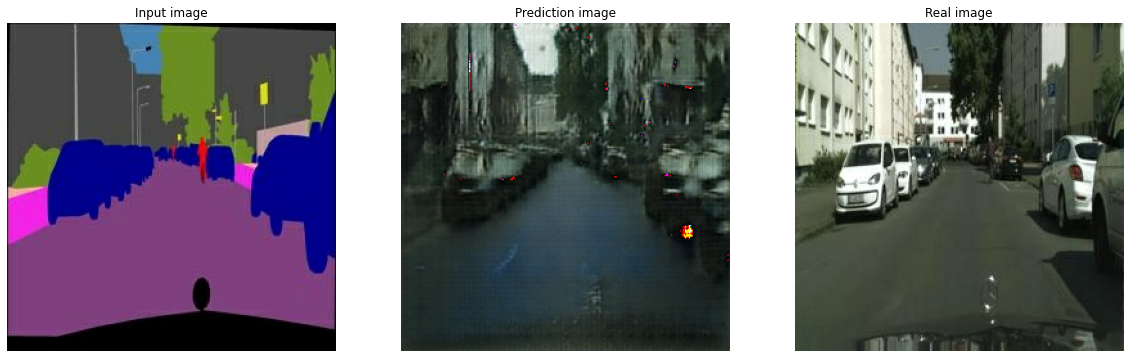

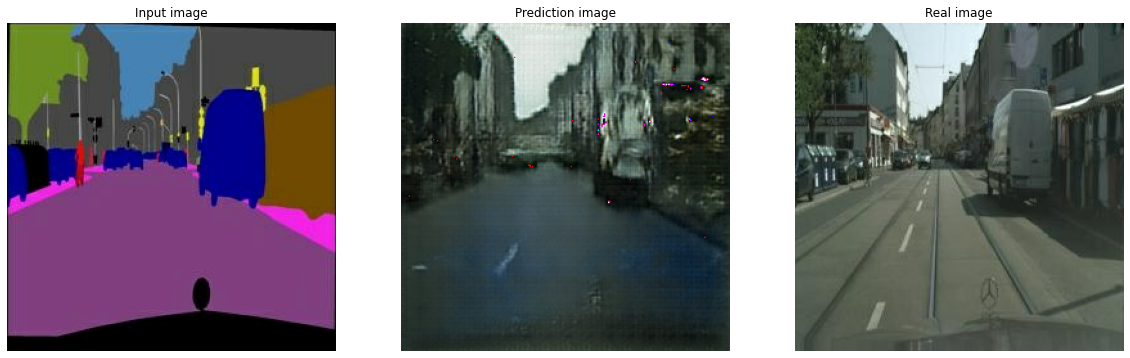

In [16]:
for i in range(len(os.listdir(val_path))):
    f = val_path + os.listdir(val_path)[i]
    colored, sketch = load_img(f)

    pred = generator(tf.expand_dims(colored, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored))
    plt.title('Input image')
    plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.title('Prediction image')
    plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(denormalize(sketch))
    plt.title('Real image')
    plt.axis('off')

- 전체적인 큰 틀은 잡혔지만, 제대로된 채색이 이뤄지지 않은 것 같습니다.
- 하지만 하늘, 건물, 도로, 차 등은 제대로 구분한것으로 보여집니다.

# 전체 회고

- CV에서 유명한 GAN에 대해서 공부하고 다뤄볼 수 있어서 좋았습니다.
- 하지만 layer를 추가하는 등의 성능 향상 방법을 사용하지 못한것은 아쉽습니다.
- 처음에 15 epochs를 돌렸을때보다 좋은 성능을 보인것 같습니다.
- 만약 더 많은 epochs를 통하여 학습했다면 해당 결과보다는 좋은 성능을 보였을것이라 생각됩니다.